Задание 1.Проекционные методы решения краевой задачи для ОДУ второго порядка
Вариант 7

![alt text](img.png)

In [105]:
import numpy as np
import scipy.integrate as integrate
from typing import Callable
from abc import ABC, abstractmethod
from scipy.integrate import quad
import matplotlib.pyplot as plt
from dataclasses import dataclass
from functools import cache
from scipy.special import jacobi

In [106]:
@dataclass(init=True)
class Variant:
    _a: float
    _b: float
    _k: int

    @property
    def a(self):
        return self._a

    @property
    def b(self):
        return self._b

    @property
    def k(self):
        return self._k

In [107]:
variant = Variant(-1, 1, 2)

In [108]:
class SecondOrderEquation:
    def __init__(self, right_side: Callable,
                 coeffs: np.ndarray):
        self._dif_operator: Callable = lambda value, dvalue, ddvalue, t: coeffs[2](t) * value + dvalue * coeffs[1](t) + coeffs[0](
            t) * ddvalue

        self._right_side: Callable = right_side

    def __call__(self, value: float, dvalue: float, ddvalue: float, t: float) -> float:
        return self._dif_operator(value, dvalue, ddvalue, t)

    def get_value(self, t: float) -> float:
        return self._right_side(t)






In [109]:
coeffs = np.array([lambda t: -(4 + t) / (5 + 2 * t), lambda t: t / 2 - 1, lambda t: (1 + np.exp(t / 2))])
equation = SecondOrderEquation(lambda t: 2 + t, coeffs)

In [110]:
class MomentsMethod:



    def __init__(self, equation: SecondOrderEquation, variant: Variant, base_funcs: np.ndarray,
                projection_funcs: np.ndarray):
        self._equation: SecondOrderEquation = equation
        self._base_funcs: np.ndarray = base_funcs
        self._a: float = variant.a
        self._b: float = variant.b
        self._k: int = variant.k
        self._projection_funcs: np.ndarray = projection_funcs

    def create_eq_matrix(self):
        self._eq_matrix = np.array([[integrate.quad(lambda t: self._equation(base_func(t), base_func.dpolynom(t),
                                                                  base_func.ddpolynom(t), t) *
                                                     projection_func(t), self._a, self._b)[0] for
                           base_func in self._base_funcs]
                           for projection_func in self._projection_funcs])



    def get_system_sol(self):
        system_right = np.array(
            [quad(lambda t: self._equation.get_value(t) * phi(t), self._a, self._b)[0] for phi in self._projection_funcs])

        system_sol = np.linalg.solve(self._eq_matrix, system_right)

        return lambda t: sum([coef * phi(t) for coef, phi in zip(system_sol, self._base_funcs)])

    @property
    def eq_matrix(self):
        return self._eq_matrix









In [111]:
class ProjPolynom:

    def __init__(self, deg: int, k:int):
        self._deg = deg
        self._k = k

    def dpolynom(self, t: float):
        if self._deg == 0:
            return 0
        return (self._deg + 2 * self._k + 1) / 2 * float(jacobi(self._deg - 1, self._k + 1,
                                                                self._k + 1)(t))

    def ddpolynom(self, t: float):
        if self._deg < 2:
            return 0
        return (self._deg + 2 * self._k + 1) / 2 * (self._deg + 2 * self._k + 2) / 2 * float(jacobi(
            self._deg - 2, self._k + 2, self._k + 2)(t))

    def __call__(self, t: float):
        return float(jacobi(self._deg, self._k, self._k)(t))


In [112]:
class Polynom:


    def __init__(self, coeffs: np.ndarray):
        self._coeffs = coeffs
        self._deg = len(coeffs) - 1

    def dpolynom(self, t: float):
        return sum([i * self._coeffs[i] * t**(i - 1) for i in range(1, self._deg + 1)])

    def ddpolynom(self, t: float):
        return sum([i * (i - 1) * self._coeffs[i] * t**(i - 2) for i in range(2, self._deg + 1)])

    def __call__(self, t: float):
        return sum([self._coeffs[i] * t**i for i in range(self._deg + 1)])


In [113]:
class BasisPolynom:

    def __init__(self, deg: int, k:int):
        self._deg = deg
        self._k = k

    def dpolynom(self, t: float):
        return -2 * (self._deg + 1) * (1 - t**2)**(self._k - 1) * float(jacobi(self._deg + 1, self._k - 1,
                                                                  self._k - 1)(t))

    def ddpolynom(self, t: float):
        return 4 * (self._deg + 1) * (self._deg + 2) * (1 - t**2)**(self._k - 2) * float(jacobi(
            self._deg + 2,self._k - 2, self._k - 2)(t))
    def __call__(self, t: float):
        return (1 - t**2)**self._k * float(jacobi(self._deg, self._k, self._k)(t))


In [114]:
class CollocationsMethod:

    def __init__(self, equation: SecondOrderEquation, variant: Variant, n: int, base_funcs: np.ndarray):
        self._equation = equation
        self._n = n
        self._a = variant.a
        self._b = variant.b
        self._nodes = None
        self._eq_matrix = None
        self._eq_solution = None
        self._base_funcs = base_funcs


    def create_nodes(self, method: str):
        if method == 'C':
            self._nodes = np.array([1 / 2 * (self._a + self._b) + 1 / 2 * (self._b - self._a) * np.cos((2 * i - 1) / (2 * self._n) * np.pi) for i in range(1, self._n + 1)])
        elif method == 'U':
            self._nodes = np.array([self._a + i * (self._b - self._a) / self._n for i in range(self._n)])

    def create_eq_matrix(self):
        self._eq_matrix = np.array([[self._equation(phi(node), phi.dpolynom(node), phi.ddpolynom(node), node) for phi in self._base_funcs] for node in self._nodes])

    def get_system_sol(self) -> Callable:
        system_right = np.array([self._equation.get_value(node) for node in self._nodes])
        system_sol = np.linalg.solve(self._eq_matrix, system_right)

        return lambda t: sum([coef * phi(t) for coef, phi in zip(system_sol, self._base_funcs)])

    @property
    def eq_matrix(self):
        return self._eq_matrix

    @property
    def nodes(self):
        return self._nodes








In [115]:
class Plotter:

    def __init__(self, variant: Variant):
        self._a = variant.a
        self._b = variant.b

    def show(self, sols: dict):
        x = np.arange(self._a, self._b, 0.01)
        fig, ax = plt.subplots(figsize = (5, 3), dpi = 200)
        ax.set_xlabel("x")
        ax.set_ylabel("y")
        for title, sol in sols.items():
            ax.plot(x, np.vectorize(sol)(x), label=title)
        ax.legend()
        ax.grid()
        plt.show()

In [118]:
def test(n: int):
    p1 = [Polynom([-11, 2, 1])]
    p2 = [Polynom([-29,0,3,2])]
    base = [ BasisPolynom(i, 2) for i in range(n - 2)]
    base = np.concatenate((p1, p2, base))
    proj = np.array([ProjPolynom(i, 0) for i in range(n)])

    moments = MomentsMethod(equation, variant, base, proj)

    moments.create_eq_matrix()
    moments_sol = moments.get_system_sol()


    colls_c = CollocationsMethod(equation, variant, n, base )
    colls_c.create_nodes("C")
    colls_c.create_eq_matrix()
    colls_c_sol = colls_c.get_system_sol()

    colls_u = CollocationsMethod(equation, variant, n, base)
    colls_u.create_nodes("U")
    colls_u.create_eq_matrix()
    colls_u_sol = colls_u.get_system_sol()


    sols = { "colls_c": colls_c_sol, "colls_u":colls_u_sol,
         "moments": moments_sol, "sol": lambda t: res.sol(t)[0]}
    plotter = Plotter(variant)

    plotter.show(sols)



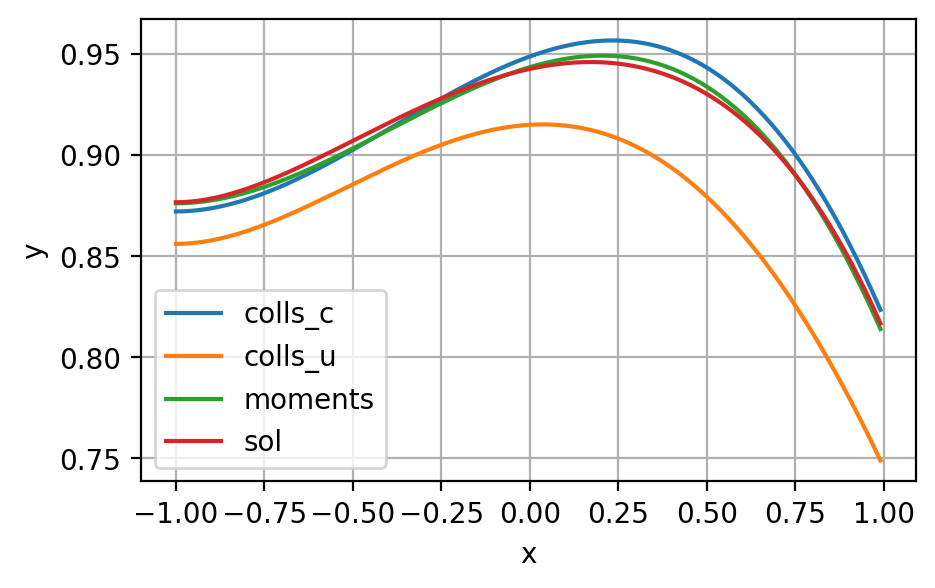

In [119]:
test(3)

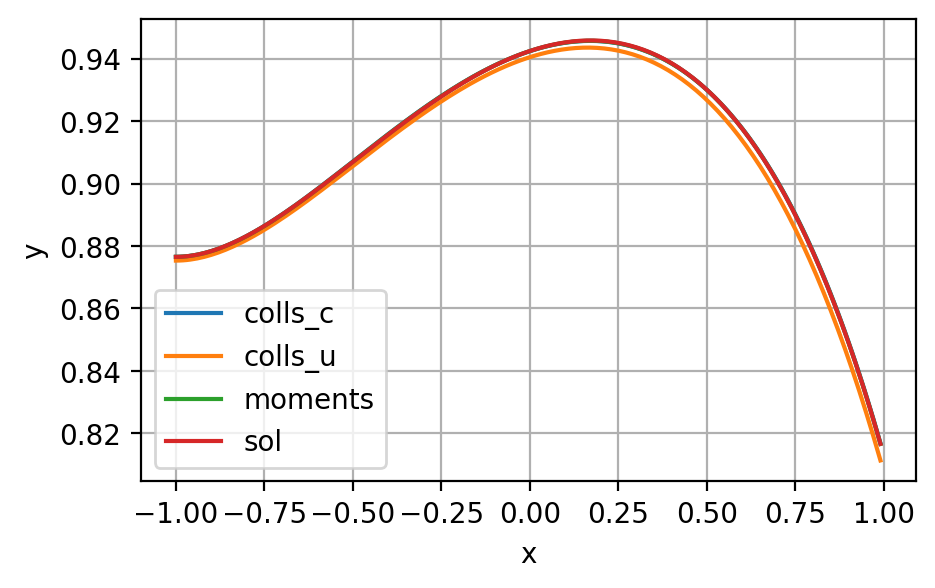

In [122]:
test(5)

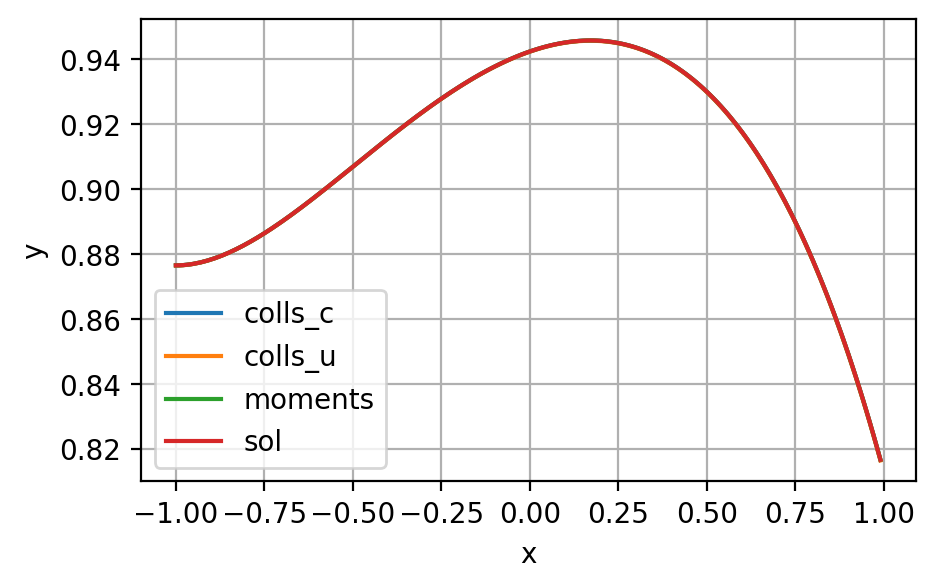

In [120]:
test(7)

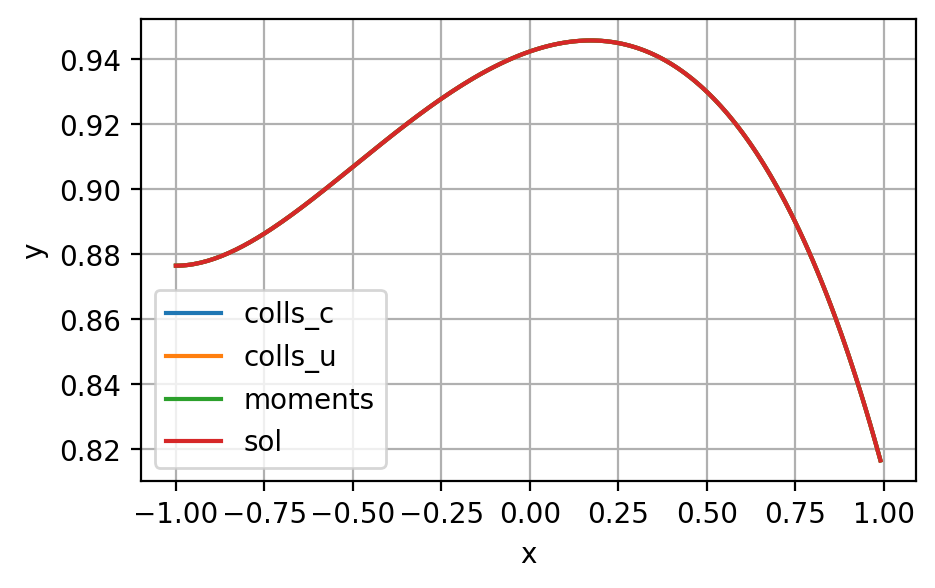

In [121]:
test(10)